# Interpredictability test
comparing the two labelers of MASS

maximum prediction length 5s

-------------------------------------------------------

In [1]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time
import sklearn.metrics as skm

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"\\COGNITION"
dreamspath=datapath+"\\DREAMS"
masspath=datapath+"\\MASS"


## load mass

In [2]:
samplerate=200  #Should rethink this

In [3]:
annotations, signalsMetadata = loadMASSSpindles(masspath,forceSamplerate=samplerate)

In [4]:
#consider to include this in a function
minDuration=0.3
maxDuration=5
annotations=annotations[annotations.type=='spindle']
annotations=annotations[annotations.duration>minDuration]
annotations=annotations[annotations.duration<maxDuration]
annotations=annotations.reset_index(drop=True)

In [5]:
annotations.head()

,type,expert,subjectId,labelerId,startTime,duration,samplerate,stopTime,startInd,stopInd
0,spindle,E1,0001,0001,888.327805,0.640579,200,888.968384,177666,177794
1,spindle,E1,0001,0001,905.758061,0.578094,200,906.336155,181152,181267
2,spindle,E1,0001,0001,917.731574,0.847603,200,918.579177,183546,183716
3,spindle,E1,0001,0001,922.078189,0.878845,200,922.957034,184416,184591
4,spindle,E1,0001,0001,939.055445,0.757767,200,939.813212,187811,187963


In [6]:
signalsMetadata.head()

,subjectId,file,channel,duration,samplerate,isOriginalSamplerate,database
0,0001,MASS_0001.pkl,C3-CLE,28956.0,200,False,MASS
1,0002,MASS_0002.pkl,C3-CLE,35016.0,200,False,MASS
2,0003,MASS_0003.pkl,C3-CLE,36760.0,200,False,MASS
3,0004,MASS_0004.pkl,C3-CLE,28004.0,200,False,MASS
4,0005,MASS_0005.pkl,C3-CLE,31244.0,200,False,MASS


## Defining the IoU matrix

In [7]:
subjectId='0007'

In [8]:
annotations1=annotations[annotations.labelerId=='0001'][annotations.subjectId=='0007'].reset_index(drop=True)
annotations2=annotations[annotations.labelerId=='0002'][annotations.subjectId=='0007'].reset_index(drop=True)

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_14784\1081862330.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  annotations1=annotations[annotations.labelerId=='0001'][annotations.subjectId=='0007'].reset_index(drop=True)
C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_14784\1081862330.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  annotations2=annotations[annotations.labelerId=='0002'][annotations.subjectId=='0007'].reset_index(drop=True)


In [9]:
len(annotations1)

912

In [10]:
len(annotations2)

1594

In [11]:
IoUmatrix=getIoUmatrix(annotations1,annotations2)

In [12]:
IoUmatrix.shape

(912, 1594)

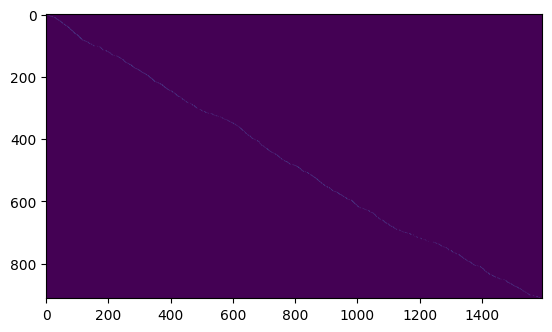

In [13]:
plt.imshow(IoUmatrix)

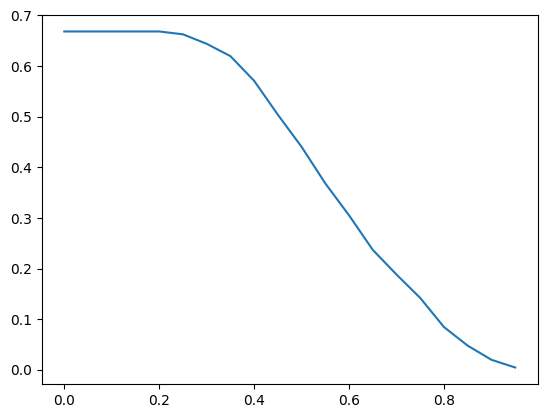

In [14]:
sampleIoUs=np.linspace(0,0.95,20)
sampleF1=[]

for thresIoU in sampleIoUs:
    sampleF1.append(IoUmatrixToF1(IoUmatrix,thresIoU))

plt.plot(sampleIoUs,sampleF1)

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_14784\3186219920.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  annotations1=annotations[annotations.labelerId=='0001'][annotations.subjectId==subjectId].reset_index(drop=True)
C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_14784\3186219920.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  annotations2=annotations[annotations.labelerId=='0002'][annotations.subjectId==subjectId].reset_index(drop=True)


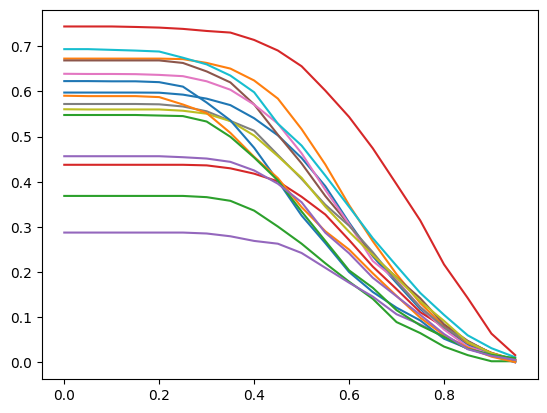

In [15]:
for subjectId in np.unique(annotations[annotations.labelerId=='0002'].subjectId):
    annotations1=annotations[annotations.labelerId=='0001'][annotations.subjectId==subjectId].reset_index(drop=True)
    annotations2=annotations[annotations.labelerId=='0002'][annotations.subjectId==subjectId].reset_index(drop=True)
    IoUmatrix=getIoUmatrix(annotations1,annotations2)
    
    sampleF1=[]
    for thresIoU in sampleIoUs:
        sampleF1.append(IoUmatrixToF1(IoUmatrix,thresIoU))

    plt.plot(sampleIoUs,sampleF1)
plt.show()

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_14784\851316360.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  annotations1=annotations[annotations.labelerId=='0001'][annotations.subjectId==subjectId].reset_index(drop=True)
C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_14784\851316360.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  annotations2=annotations[annotations.labelerId=='0002'][annotations.subjectId==subjectId].reset_index(drop=True)


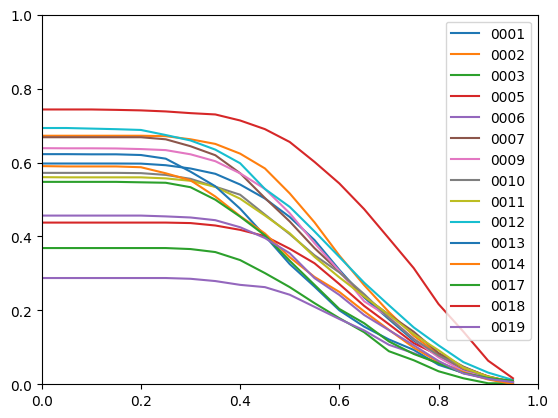

In [16]:
sampleF1_0=np.zeros((len(sampleIoUs),len(np.unique(annotations[annotations.labelerId=='0002'].subjectId))))
j=0
for subjectId in np.unique(annotations[annotations.labelerId=='0002'].subjectId):
    annotations1=annotations[annotations.labelerId=='0001'][annotations.subjectId==subjectId].reset_index(drop=True)
    annotations2=annotations[annotations.labelerId=='0002'][annotations.subjectId==subjectId].reset_index(drop=True)
    IoUmatrix=getIoUmatrix(annotations1,annotations2)
        
    i=0
    for thresIoU in sampleIoUs:
        sampleF1_0[i,j]=IoUmatrixToF1(IoUmatrix,thresIoU)
        i=i+1
    j=j+1
plt.plot(sampleIoUs,sampleF1_0)
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.legend(np.unique(annotations[annotations.labelerId=='0002'].subjectId))

Text(0, 0.5, 'F1*')

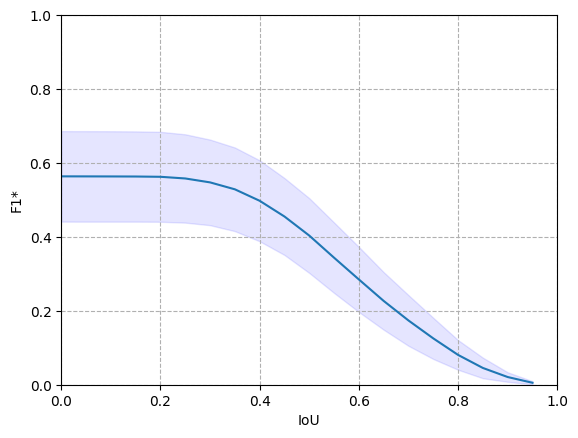

In [17]:
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.plot(sampleIoUs,np.mean(sampleF1_0,1))
ax.fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('IoU')
ax.set_ylabel('F1*')


## Detecting a pathological case

In [18]:
subjectId='0001'
annotations1=annotations[annotations.labelerId=='0001'][annotations.subjectId==subjectId].reset_index(drop=True)
annotations2=annotations[annotations.labelerId=='0002'][annotations.subjectId==subjectId].reset_index(drop=True)

annotationPairToGraph(annotations1,annotations2,thresIoU=0)

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_14784\2269940157.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  annotations1=annotations[annotations.labelerId=='0001'][annotations.subjectId==subjectId].reset_index(drop=True)
C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_14784\2269940157.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  annotations2=annotations[annotations.labelerId=='0002'][annotations.subjectId==subjectId].reset_index(drop=True)


In [19]:
len(annotations1)

1044

In [20]:
annotations1.iloc[874]

type               spindle
expert                  E1
subjectId             0001
labelerId             0001
startTime     25328.410141
duration          0.624962
samplerate             200
stopTime      25329.035103
startInd           5065682
stopInd            5065807
Name: 874, dtype: object

In [21]:
labels1=loadLabelsVector([subjectId],annotations1,signalsMetadata,samplerate=200)
labels2=loadLabelsVector([subjectId],annotations2,signalsMetadata,samplerate=200)

In [91]:
signals,_,_=loadMASSSpindles(masspath,returnSignals=True)
signal=signals['0001']
signal=sg.resample_poly(signal,up=25,down=32)

In [92]:
roi=[5065500,5066500]
timepoints=np.arange(0,roi[1]-roi[0])/samplerate

Text(0.5, 0, 'time / s')

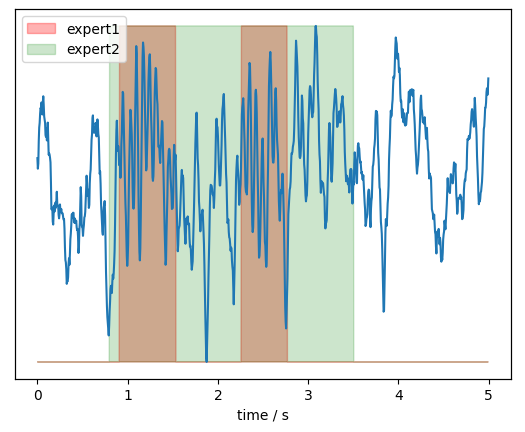

In [100]:
fig, ax1 = plt.subplots()
ax1.fill(timepoints,labels1[roi[0]:roi[1]],alpha=0.3,label='expert1',color='r')
ax1.fill(timepoints,labels2[roi[0]:roi[1]],alpha=0.2,label='expert2',color='g')
ax1.legend(loc='upper left')
ax1.set_yticks([])
ax2=ax1.twinx()
ax2.plot(timepoints,signal[roi[0]:roi[1]])
ax2.set_yticks([])
ax1.set_xlabel("time / s")

In [70]:
from plotly.subplots import make_subplots

roi=[5065500,5066500]

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(y=labels1[roi[0]:roi[1]], fill='tozeroy',mode='none',name='expert1'))
fig.add_trace(go.Scatter(y=labels2[roi[0]:roi[1]]*1, fill='tozeroy',mode='none',name='expert2'))
#fig.add_trace(go.Scatter(y=testLabels[roi[0]:roi[1]], fill='tozeroy',mode='none',name='GT'))
#fig.add_trace(go.Scatter(y=signals[subjectId][roi[0]:roi[1]],name='signal'), secondary_y=True)
fig.show()

In [ ]:
from plotly.subplots import make_subplots

roi=[5065500,5066500]

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(y=labels1[roi[0]:roi[1]], fill='tozeroy',mode='none',name='expert1'))
fig.add_trace(go.Scatter(y=labels2[roi[0]:roi[1]]*1, fill='tozeroy',mode='none',name='expert2'))
#fig.add_trace(go.Scatter(y=testLabels[roi[0]:roi[1]], fill='tozeroy',mode='none',name='GT'))
#fig.add_trace(go.Scatter(y=signals[subjectId][roi[0]:roi[1]],name='signal'), secondary_y=True)
fig.show()

In [23]:
mini1=annotations1.iloc[874:876]
mini2=annotations2.iloc[2024:2025]

In [24]:
mini1

,type,expert,subjectId,labelerId,startTime,duration,samplerate,stopTime,startInd,stopInd
874,spindle,E1,0001,0001,25328.410141,0.624962,200,25329.035103,5065682,5065807
875,spindle,E1,0001,0001,25329.761141,0.507782,200,25330.268923,5065952,5066054


In [25]:
mini2

,type,expert,subjectId,labelerId,startTime,duration,samplerate,stopTime,startInd,stopInd
2024,spindle,E2,0001,0002,25328.300322,2.702952,200,25331.003274,5065660,5066201


In [106]:
len(annotations)

33269

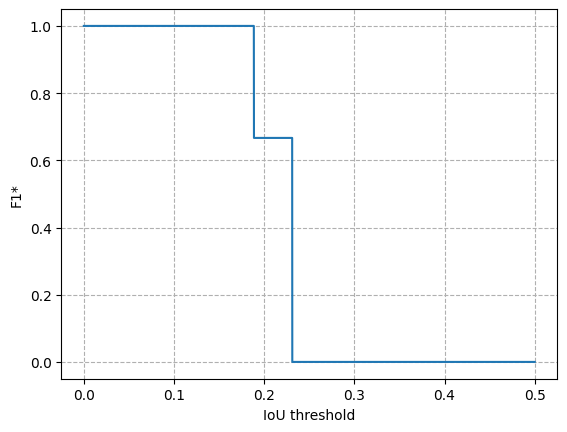

In [105]:
sampleIoUs2=np.linspace(0,0.5,10000)
sampleF1=[]

IoUmatrix=getIoUmatrix(mini1,mini2)

for thresIoU in sampleIoUs2:
    sampleF1.append(IoUmatrixToF1(IoUmatrix,thresIoU))

plt.plot(sampleIoUs2,sampleF1,linestyle='-')
#plt.vlines(x=[0.2310536,0.1885397],ymin=0,ymax=1,linestyles='--',colors='k')
plt.xlabel("IoU threshold")
plt.ylabel("F1*")
plt.grid(linestyle='--')

another case

here the expert 2 has labeled two overlapping annotations! we can not visualise it as before

In [27]:
subjectId='0011'
annotations1=annotations[annotations.labelerId=='0001'][annotations.subjectId==subjectId].reset_index(drop=True)
annotations2=annotations[annotations.labelerId=='0002'][annotations.subjectId==subjectId].reset_index(drop=True)

annotationPairToGraph(annotations1,annotations2,thresIoU=0)

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_14784\787206232.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_14784\787206232.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [28]:
len(annotations1)

606

In [29]:
annotations1.iloc[424]

type               spindle
expert                  E1
subjectId             0011
labelerId             0001
startTime      18820.45651
duration          1.109306
samplerate             200
stopTime      18821.565816
startInd           3764091
stopInd            3764313
Name: 424, dtype: object

In [30]:
annotations2.iloc[1247:1249]

,type,expert,subjectId,labelerId,startTime,duration,samplerate,stopTime,startInd,stopInd
1247,spindle,E2,0011,0002,18820.275470,1.288980,200,18821.56445,3764055,3764313
1248,spindle,E2,0011,0002,18821.283218,0.320292,200,18821.60351,3764257,3764321


notice this two annotations of the second expert overlap

## Save all graphs from the expert comparison

In [31]:
for subjectId in np.unique(annotations[annotations.labelerId=='0002'].subjectId):
    annotations1=annotations[annotations.labelerId=='0001'][annotations.subjectId==subjectId].reset_index(drop=True)
    annotations2=annotations[annotations.labelerId=='0002'][annotations.subjectId==subjectId].reset_index(drop=True)

    fig=annotationPairToGraph(annotations1,annotations2,thresIoU=0)
    fig.write_html("graph_"+subjectId+".html")

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_14784\1257507985.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_14784\1257507985.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_14784\1257507985.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_14784\1257507985.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_14784\1257507985.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_14784\1257507985.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_14784\1257507985.py:2: UserWarning:

Boolean Series key will be reindexe

## labeler1 model predicts labeler2

In [32]:
experimentId="5388ca14-a315-4598-97c2-d44175b24937"

In [33]:
experimentModels, featureSelection = loadExperiment(experimentId,datapath)

In [34]:
experimentModels1=experimentModels[experimentModels.criteriumName=='E1'].reset_index(drop=True)
experimentModels2=experimentModels[experimentModels.criteriumName=='E2'].reset_index(drop=True)

In [35]:
#Hyper params for E1
hyperClose=0.1
hyperDuration=0.3
hyperThres=0.3
hyperDepth=30

In [36]:
annotationsN2=pd.read_csv(datapath+'/MASS/annotations/spindlesFilteredN2.csv')
annotationsN2['samplerate']=samplerate
annotationsN2['subjectId']=annotationsN2.apply(
    lambda row: str(row.subjectId).zfill(4),axis=1)
annotationsN2['labelerId']=annotationsN2.apply(
    lambda row: str(row.labelerId).zfill(4),axis=1)
annotationsN2['stopTime']=annotationsN2.apply(
    lambda row: row.startTime+row.duration , axis=1)
annotationsN2['startInd']=annotationsN2.apply(
    lambda row: seconds2index(row.startTime,row.samplerate) , axis=1)
annotationsN2['stopInd']=annotationsN2.apply(
    lambda row: seconds2index(row.stopTime,row.samplerate) , axis=1)

In [37]:
## load hypnograms
stagesAnnotations=pd.read_csv(datapath+"\MASS\stages\stages.csv")
stagesAnnotations['samplerate']=samplerate
stagesAnnotations['subjectId']=stagesAnnotations.apply(
    lambda row: str(row.subjectId).zfill(4),axis=1)
stagesAnnotations['stopTime']=stagesAnnotations.apply(
    lambda row: row.startTime+row.duration , axis=1)
stagesAnnotations['startInd']=stagesAnnotations.apply(
    lambda row: seconds2index(row.startTime,row.samplerate) , axis=1)
stagesAnnotations['stopInd']=stagesAnnotations.apply(
    lambda row: seconds2index(row.stopTime,row.samplerate) , axis=1)
stagesAnnotations.head(5)

hypnograms={}
for ind, row in signalsMetadata.iterrows():
    subjectId=row.subjectId
    thisStages=stagesAnnotations[stagesAnnotations.subjectId==subjectId]
    excerptDimension=int(row.duration*row.samplerate)
    thisHypnogram=np.ones((excerptDimension,))*np.nan
    for ind_stg, row_stg in thisStages.iterrows():
        thisHypnogram[row_stg.startInd:row_stg.stopInd]=row_stg.value
    hypnograms[subjectId]=thisHypnogram   

In [38]:
sampleF1_1=np.zeros((len(sampleIoUs),len(np.unique(annotations[annotations.labelerId=='0002'].subjectId))))
j=0
for ind,row in experimentModels1.iterrows():
    print('*************************')
    print(str(ind+1)+' of '+str(len(experimentModels1)) )
    #load model
    model=loadBooster(row.modelId,experimentId,datapath)

    testSubjectId=row.test
    testHypnogram=hypnograms[testSubjectId]
    testN2Mask=testHypnogram==2
    
    #Define annotations criterium   *********************************************
    usedAnnotations=annotationsN2[annotationsN2.labelerId=='0002'].reset_index(drop=True)
    #***************************************************************************

    #Load features and labels
    testFeatures=loadFeatureMatrix([testSubjectId],featureSelection,signalsMetadata,samplerate,datapath)
    testLabels=loadLabelsVector([testSubjectId],usedAnnotations,signalsMetadata,samplerate)

    #Predict
    testDMatrix=xgb.DMatrix(data=testFeatures)
    probabilities=model.predict(testDMatrix,iteration_range=(0,hyperDepth))
    rawLabels=probabilities>=hyperThres

    #Apply mask ---------------------------------->
    rawLabels=rawLabels*testN2Mask
    #<---------------------------------------------

    #Process
    processedLabels=labelingProcess(rawLabels,hyperClose,hyperDuration,samplerate)

    #By-event metrics
    processedAnnotations=labelVectorToAnnotations(processedLabels,samplerate)
    
    #**********************************************
    processedAnnotations=processedAnnotations[processedAnnotations.duration<5]
    #**********************************************

    gtAnnotations=labelVectorToAnnotations(testLabels,samplerate)   #<- or just filter the annotations
    
    IoUmatrix=getIoUmatrix(gtAnnotations,processedAnnotations)
        
    i=0
    for thresIoU in sampleIoUs:
        sampleF1_1[i,j]=IoUmatrixToF1(IoUmatrix,thresIoU)
        i=i+1
    j=j+1    
    

*************************
1 of 15
*************************
2 of 15
*************************
3 of 15
*************************
4 of 15
*************************
5 of 15
*************************
6 of 15
*************************
7 of 15
*************************
8 of 15
*************************
9 of 15
*************************
10 of 15
*************************
11 of 15
*************************
12 of 15
*************************
13 of 15
*************************
14 of 15
*************************
15 of 15


## labeler2 model predicts labeler1

In [39]:
#Hyper params for E2
hyperClose=0.1
hyperDuration=0.3
hyperThres=0.3
hyperDepth=40

In [40]:
sampleF1_2=np.zeros((len(sampleIoUs),len(np.unique(annotations[annotations.labelerId=='0002'].subjectId))))
j=0
for ind,row in experimentModels2.iterrows():
    print('*************************')
    print(str(ind+1)+' of '+str(len(experimentModels2)) )
    #load model
    model=loadBooster(row.modelId,experimentId,datapath)

    testSubjectId=row.test
    testHypnogram=hypnograms[testSubjectId]
    testN2Mask=testHypnogram==2
    
    #Define annotations criterium   *********************************************
    usedAnnotations=annotationsN2[annotationsN2.labelerId=='0001'].reset_index(drop=True)
    #***************************************************************************

    #Load features and labels
    testFeatures=loadFeatureMatrix([testSubjectId],featureSelection,signalsMetadata,samplerate,datapath)
    testLabels=loadLabelsVector([testSubjectId],usedAnnotations,signalsMetadata,samplerate)

    #Predict
    testDMatrix=xgb.DMatrix(data=testFeatures)
    probabilities=model.predict(testDMatrix,iteration_range=(0,hyperDepth))
    rawLabels=probabilities>=hyperThres

    #Apply mask ---------------------------------->
    rawLabels=rawLabels*testN2Mask
    #<---------------------------------------------

    #Process
    processedLabels=labelingProcess(rawLabels,hyperClose,hyperDuration,samplerate)

    #By-event metrics
    processedAnnotations=labelVectorToAnnotations(processedLabels,samplerate)
    
    #**********************************************
    processedAnnotations=processedAnnotations[processedAnnotations.duration<5]
    #**********************************************
    
    gtAnnotations=labelVectorToAnnotations(testLabels,samplerate)   #<- or just filter the annotations
    
    IoUmatrix=getIoUmatrix(gtAnnotations,processedAnnotations)
        
    i=0
    for thresIoU in sampleIoUs:
        sampleF1_2[i,j]=IoUmatrixToF1(IoUmatrix,thresIoU)
        i=i+1
    j=j+1    

*************************
1 of 15
*************************
2 of 15
*************************
3 of 15
*************************
4 of 15
*************************
5 of 15
*************************
6 of 15
*************************
7 of 15
*************************
8 of 15
*************************
9 of 15
*************************
10 of 15
*************************
11 of 15
*************************
12 of 15
*************************
13 of 15
*************************
14 of 15
*************************
15 of 15


## Interpredictability test

In [41]:
sampleIoUs

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

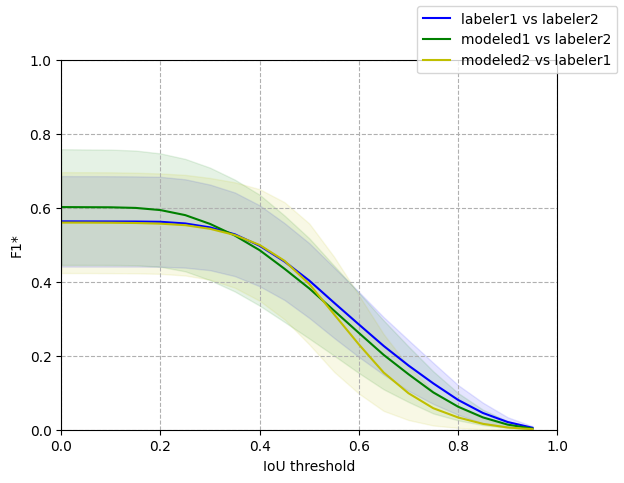

In [68]:
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax.plot(sampleIoUs,np.mean(sampleF1_1,1),color='g')
ax.plot(sampleIoUs,np.mean(sampleF1_2,1),color='y')
ax.fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_1,1)-1*np.std(sampleF1_1,1), np.mean(sampleF1_1,1)+1*np.std(sampleF1_1,1), color='g', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_2,1)-1*np.std(sampleF1_2,1), np.mean(sampleF1_2,1)+1*np.std(sampleF1_2,1), color='y', alpha=.1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('IoU threshold')
ax.set_ylabel('F1*')
fig.legend(['labeler1 vs labeler2','modeled1 vs labeler2','modeled2 vs labeler1'])

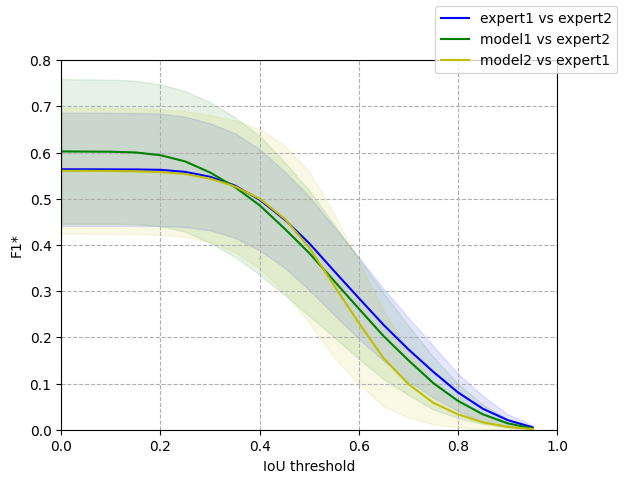

In [107]:
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax.plot(sampleIoUs,np.mean(sampleF1_1,1),color='g')
ax.plot(sampleIoUs,np.mean(sampleF1_2,1),color='y')
ax.fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_1,1)-1*np.std(sampleF1_1,1), np.mean(sampleF1_1,1)+1*np.std(sampleF1_1,1), color='g', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_2,1)-1*np.std(sampleF1_2,1), np.mean(sampleF1_2,1)+1*np.std(sampleF1_2,1), color='y', alpha=.1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 0.8])
ax.set_xlabel('IoU threshold')
ax.set_ylabel('F1*')
fig.legend(['expert1 vs expert2','model1 vs expert2','model2 vs expert1'])

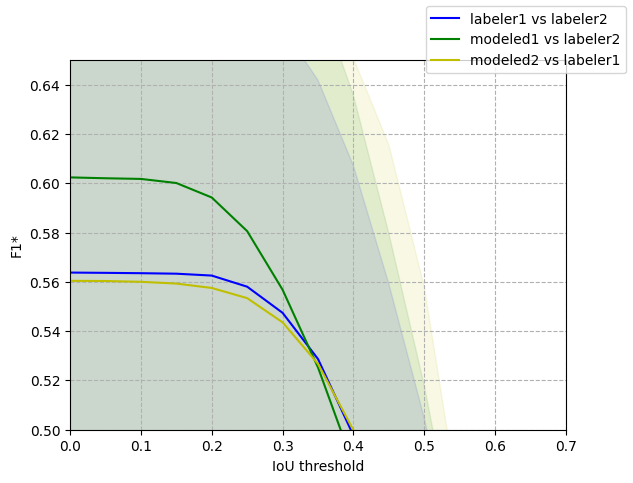

In [60]:
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax.plot(sampleIoUs,np.mean(sampleF1_1,1),color='g')
ax.plot(sampleIoUs,np.mean(sampleF1_2,1),color='y')
ax.fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_1,1)-1*np.std(sampleF1_1,1), np.mean(sampleF1_1,1)+1*np.std(sampleF1_1,1), color='g', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_2,1)-1*np.std(sampleF1_2,1), np.mean(sampleF1_2,1)+1*np.std(sampleF1_2,1), color='y', alpha=.1)
ax.set_xlim([0, 0.7])
ax.set_ylim([0.5, 0.65])
ax.set_xlabel('IoU threshold')
ax.set_ylabel('F1*')
fig.legend(['labeler1 vs labeler2','modeled1 vs labeler2','modeled2 vs labeler1'])

In [45]:
experimentModels2.test[0]

'0001'

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_14784\1520291559.py:13: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



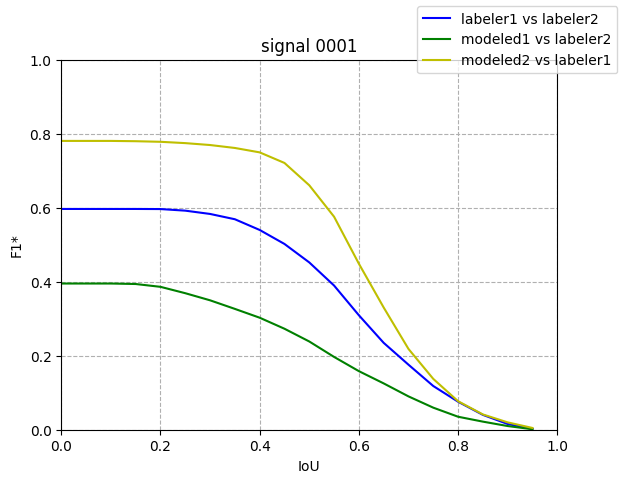

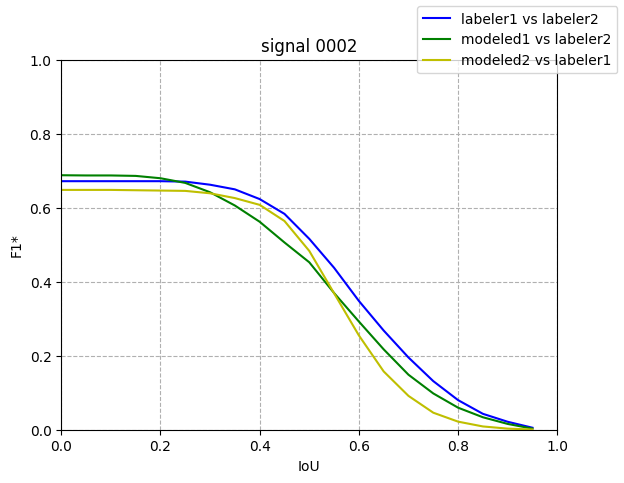

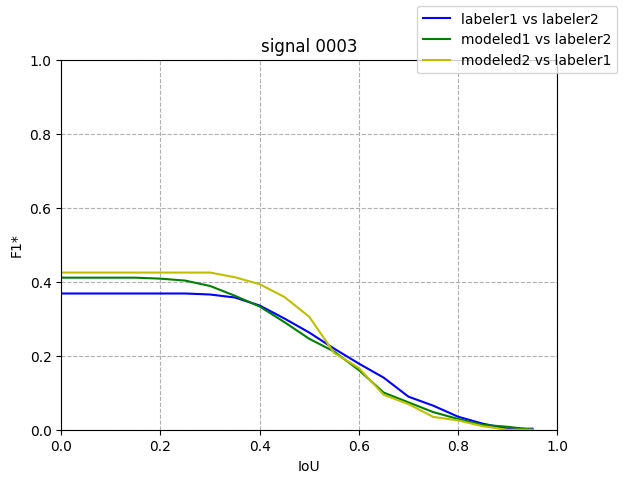

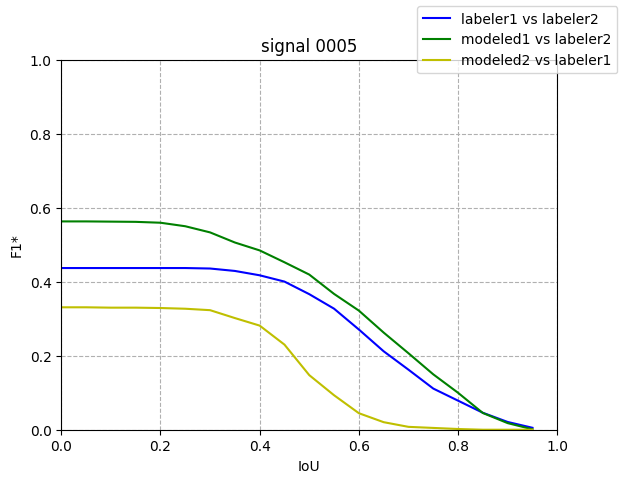

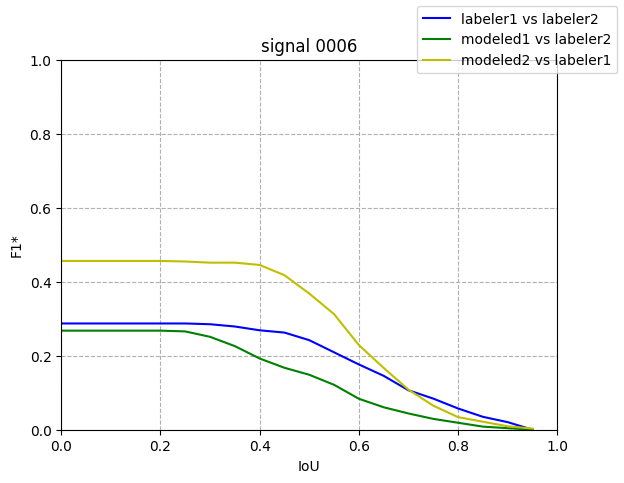

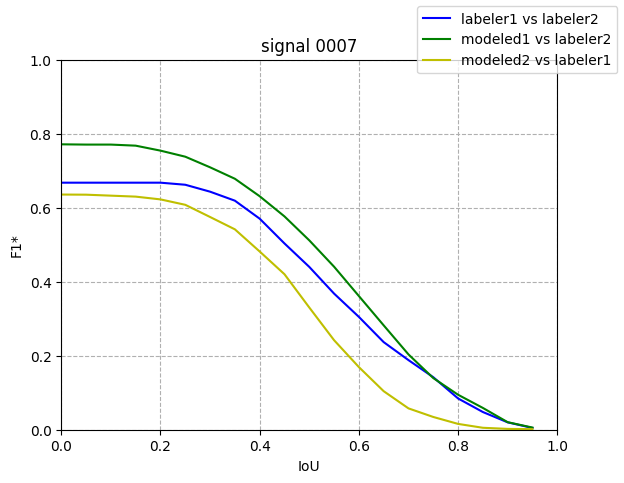

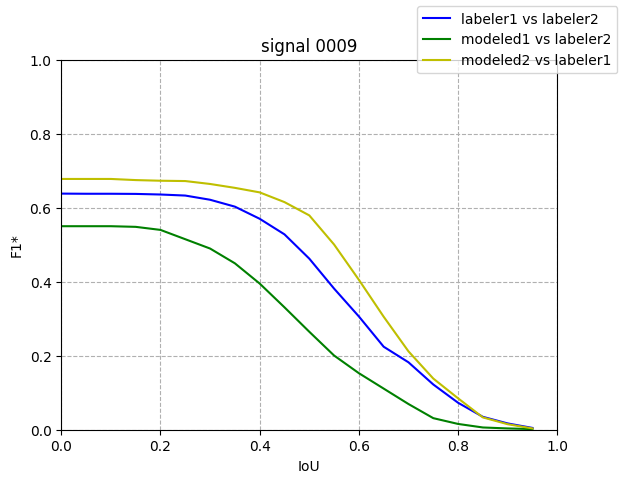

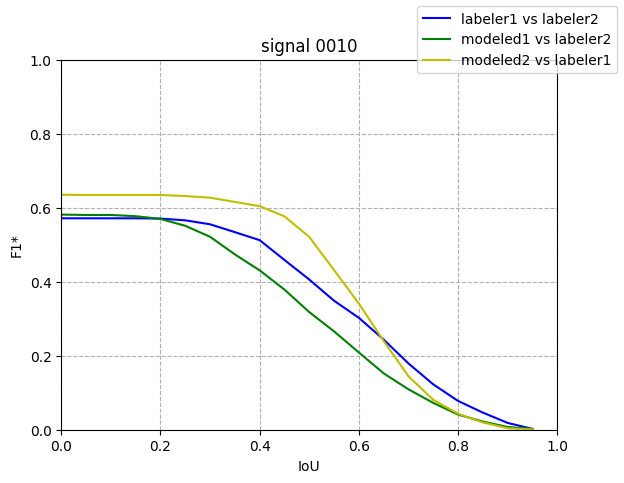

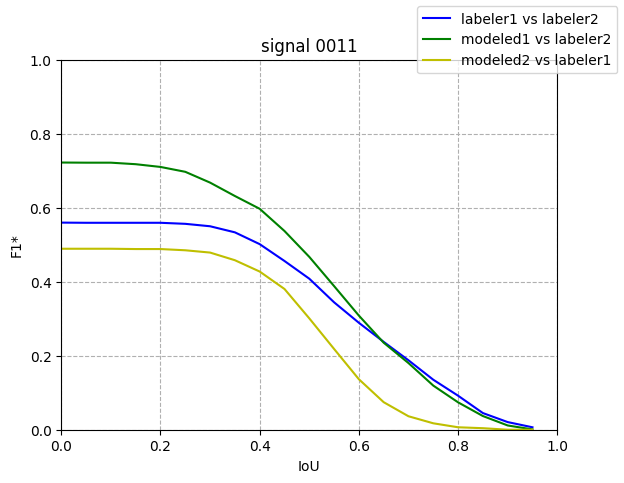

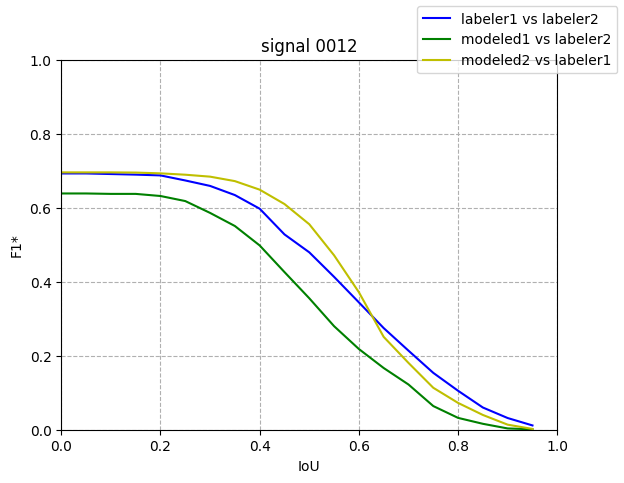

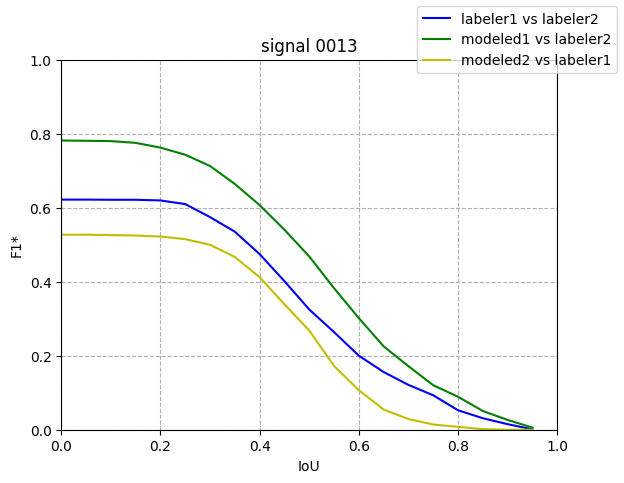

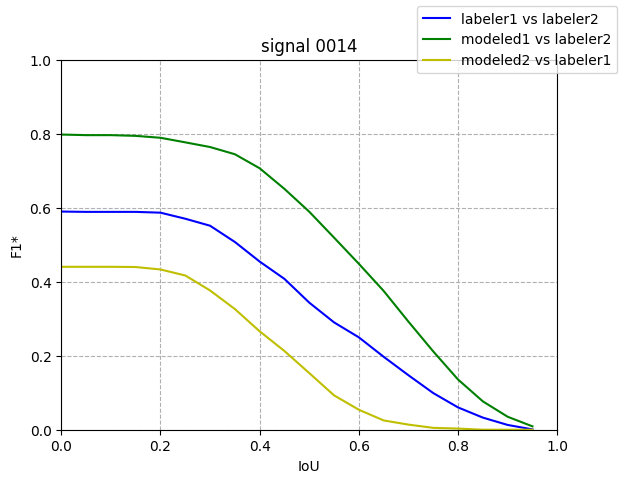

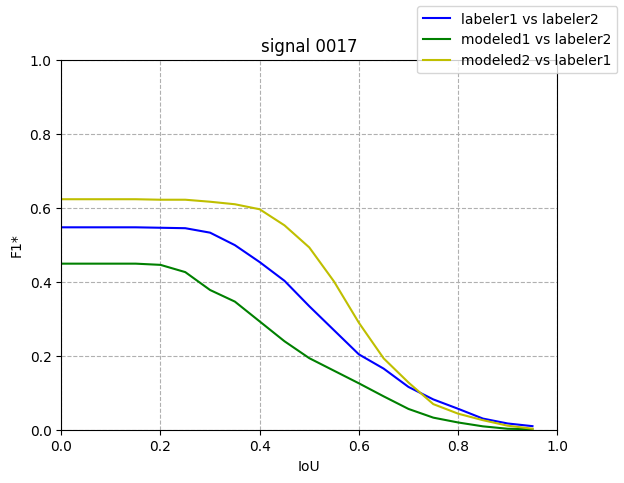

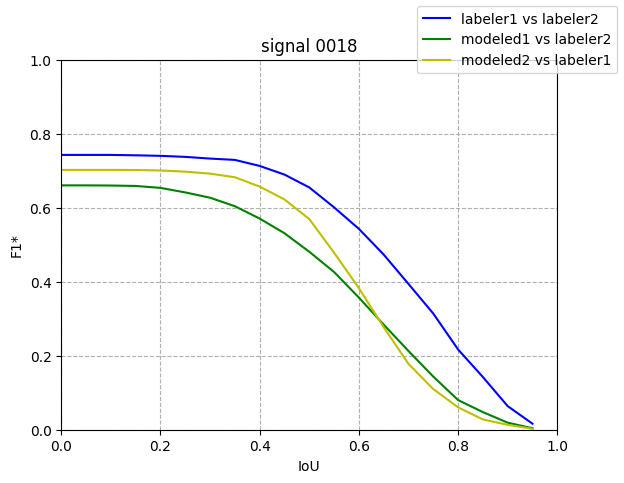

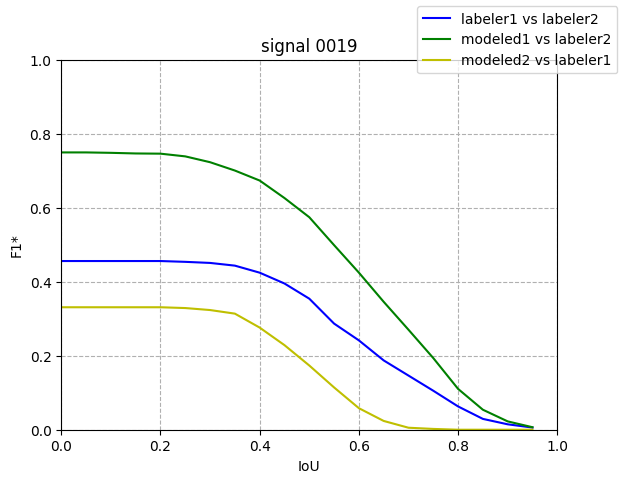

In [59]:
for i in range(sampleF1_0.shape[1]):
    fig, ax = plt.subplots()
    ax.grid(linestyle='--')
    ax.plot(sampleIoUs,sampleF1_0[:,i].flatten(),color='b')
    ax.plot(sampleIoUs,sampleF1_1[:,i],color='g')
    ax.plot(sampleIoUs,sampleF1_2[:,i],color='y')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('IoU')
    ax.set_ylabel('F1*')
    fig.legend(['labeler1 vs labeler2','modeled1 vs labeler2','modeled2 vs labeler1'])
    plt.title('signal '+experimentModels2.test[i])
    fig.show()

In [47]:
sampleF1_3=(sampleF1_1+sampleF1_2)/2

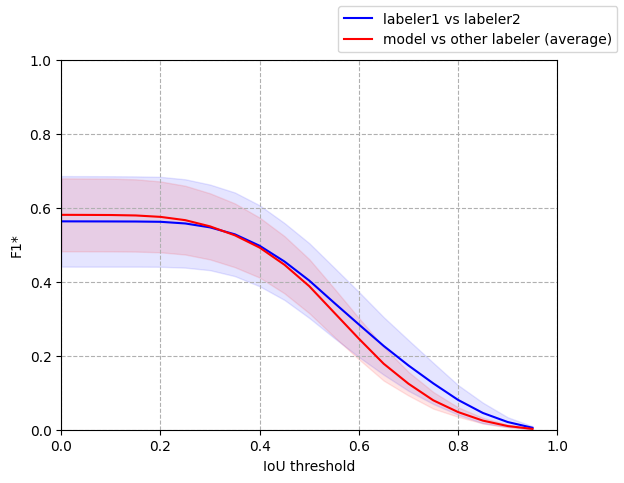

In [57]:
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax.plot(sampleIoUs,np.mean(sampleF1_3,1),color='r')
ax.fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_3,1)-1*np.std(sampleF1_3,1), np.mean(sampleF1_3,1)+1*np.std(sampleF1_3,1), color='r', alpha=.1)
ax.set_xlim([0, 1])
ax.set_ylim([0,1])
ax.set_xlabel('IoU threshold')
ax.set_ylabel('F1*')
fig.legend(['labeler1 vs labeler2','model vs other labeler (average)'])

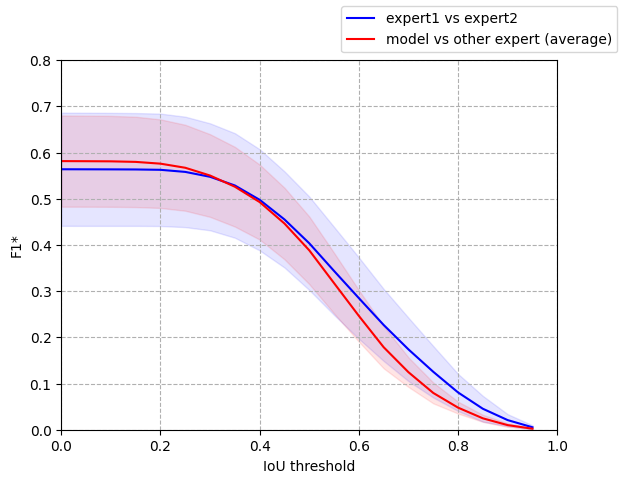

In [108]:
fig, ax = plt.subplots()
ax.grid(linestyle='--')
ax.plot(sampleIoUs,np.mean(sampleF1_0,1),color='b')
ax.plot(sampleIoUs,np.mean(sampleF1_3,1),color='r')
ax.fill_between(sampleIoUs, np.mean(sampleF1_0,1)-1*np.std(sampleF1_0,1), np.mean(sampleF1_0,1)+1*np.std(sampleF1_0,1), color='b', alpha=.1)
ax.fill_between(sampleIoUs, np.mean(sampleF1_3,1)-1*np.std(sampleF1_3,1), np.mean(sampleF1_3,1)+1*np.std(sampleF1_3,1), color='r', alpha=.1)
ax.set_xlim([0, 1])
ax.set_ylim([0,0.8])
ax.set_xlabel('IoU threshold')
ax.set_ylabel('F1*')
fig.legend(['expert1 vs expert2','model vs other expert (average)'])